In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
import cv2
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
import tensorflow as tf
import matplotlib.image as mpimg
from PIL import Image
from sklearn.utils import resample
from tensorflow.keras.preprocessing import image
from scipy.ndimage import gaussian_filter
import os
import shutil

In [6]:
from tensorflow.keras.models import load_model

# Load the model using TensorFlow's built-in method
model = load_model('D:/DATASET/Models/model_ballooning.h5')

In [7]:
def preprocess_and_predict(img_path, model):
    """
    Process an image file to predict hepatocyte ballooning using a trained model.

    Parameters:
    - img_path: string, path to the user's liver biopsy image.
    - model: loaded TensorFlow model trained to detect hepatocyte ballooning.

    Returns:
    - prediction: int, predicted class (0 for no ballooning, 1 for ballooning present).
    - prob: float, probability of the class prediction.
    """
    # Load the image
    img = image.load_img(img_path, target_size=(299, 299), color_mode='rgb')
    img_array = image.img_to_array(img)

    # Convert to grayscale
    gray = np.dot(img_array[..., :3], [0.2989, 0.5870, 0.1140])
    
    # Apply Gaussian filter
    filtered = gaussian_filter(gray, sigma=1)

    # Normalize the image
    filtered /= 255.0
    
    # Reshape for the model
    filtered = np.expand_dims(filtered, axis=-1)  # Add channel dimension
    filtered = np.repeat(filtered, 3, axis=-1)  # Make 3 channel for ResNet input
    filtered = np.expand_dims(filtered, axis=0)  # Add batch dimension

    # Predict using the model
    predictions = model.predict(filtered)
    predicted_class = np.argmax(predictions, axis=1)[0]
    probability = np.max(predictions, axis=1)[0]

    # Plot the processed image
    plt.imshow(filtered[0], cmap='gray')
    plt.title(f'Processed Image - Predicted Class: {predicted_class}, Probability: {probability:.2f}')
    plt.show()

    return predicted_class, probability

1/1 [==============================] - 0s 254ms/step


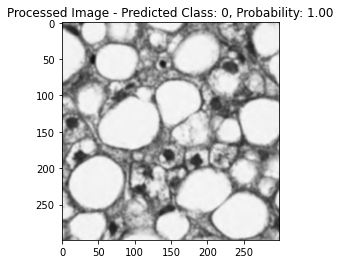

Predicted Class: 0 (0: No Ballooning, 1: Ballooning Present), Probability: 1.00


In [10]:
img_path = "D:/DATASET/CNN/ballooning/train/0/14_131_47.png"
predicted_class, probability = preprocess_and_predict(img_path, model)
print(f'Predicted Class: {predicted_class} (0: No Ballooning, 1: Ballooning Present), Probability: {probability:.2f}')

In [ ]:
def preprocess_image(image_path):
    """Preprocess the input image."""
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_rgb

def extract_patches(image, patch_size=299, stride=100):
    """Extract patches from the input image."""
    patches = []
    height, width, _ = image.shape
    for y in range(0, height - patch_size + 1, stride):
        for x in range(0, width - patch_size + 1, stride):
            patch = image[y:y+patch_size, x:x+patch_size]
            if patch.shape[0] == patch.shape[1] == patch_size:
                patches.append(patch)
    return patches

def predict_nash_score(patch, model):
    """Predict the NASH score for a single patch."""
    # Preprocess the patch
    patch_preprocessed = patch / 255.0  # Normalize
    patch_preprocessed = np.expand_dims(patch_preprocessed, axis=0)

    # Make prediction using the model
    prediction = model.predict(patch_preprocessed)
    return prediction[0][0]  # NASH score

def predict_average_nash_score(image_path, model):
    """Predict the average NASH score for the input image."""
    # Preprocess the input image
    image = preprocess_image(image_path)

    # Extract patches from the input image
    patches = extract_patches(image)

    # Predict the NASH score for each patch
    nash_scores = [predict_nash_score(patch, model) for patch in patches]

    # Calculate the average NASH score
    average_nash_score = np.mean(nash_scores)

    # Round off the average NASH score to the nearest integer
    result_nash_score = round(average_nash_score)

    return result_nash_score

def show_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.show()
    
    
# Example usage
image_path = "D:/Testing (Triya ma'am)/Hematoxylin eosin staining for scoring at 20X and 40x/Healthy_40x/16.jpeg"
show_image(image_path)
result_nash_score = predict_average_nash_score(image_path, model)
print("Predicted NASH score:", result_nash_score)

if result_nash_score==0:
    print("0: Ballooning absent")
else:
    print("1: Ballooning present")


In [ ]:
image_path = "D:/Testing (Triya ma'am)/Hematoxylin eosin staining for scoring at 20X and 40x/NASH_40x/10.jpeg"  # Update with the path to the user-input image


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def preprocess_image(image_path):
    """Preprocess the input image."""
    # Read the image
    img = cv2.imread(image_path)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply adaptive thresholding to highlight circular regions
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Find contours of circular regions
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Create a mask for circular regions
    mask = np.zeros_like(thresh)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if 200 < area < 5000:  # Adjust area threshold as per requirement
            cv2.drawContours(mask, [cnt], -1, 255, -1)
    # Bitwise AND operation to mask circular regions
    masked_image = cv2.bitwise_and(img, img, mask=mask)
    # Convert masked image to RGB
    img_rgb = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
    return img_rgb

def extract_patches(image, patch_size=299, stride=100):
    """Extract patches from the input image."""
    patches = []
    height, width, _ = image.shape
    for y in range(0, height - patch_size + 1, stride):
        for x in range(0, width - patch_size + 1, stride):
            patch = image[y:y+patch_size, x:x+patch_size]
            if patch.shape[0] == patch.shape[1] == patch_size:
                patches.append(patch)
    return patches

def predict_nash_score(patch, model):
    """Predict the NASH score for a single patch."""
    # Preprocess the patch
    patch_preprocessed = patch / 255.0  # Normalize
    patch_preprocessed = np.expand_dims(patch_preprocessed, axis=0)

    # Make prediction using the model
    prediction = model.predict(patch_preprocessed)
    return prediction[0][0]  # NASH score

def predict_average_nash_score(image_path, model):
    """Predict the average NASH score for the input image."""
    # Preprocess the input image
    image = preprocess_image(image_path)

    # Extract patches from the input image
    patches = extract_patches(image)

    # Predict the NASH score for each patch
    nash_scores = [predict_nash_score(patch, model) for patch in patches]

    # Calculate the average NASH score
    average_nash_score = np.mean(nash_scores)

    # Round off the average NASH score to the nearest integer
    result_nash_score = round(average_nash_score)

    return result_nash_score

def show_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.show()
    
    
# Example usage
image_path = "D:/Testing (Triya ma'am)/Hematoxylin eosin staining for scoring at 20X and 40x/Healthy_40x/16.jpeg"
show_image(image_path)
result_nash_score = predict_average_nash_score(image_path, model)
print("Predicted NASH score:", result_nash_score)

if result_nash_score == 0:
    print("0: Ballooning absent")
else:
    print("1: Ballooning present")


In [ ]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import load_model

def preprocess_image(image):
    """Preprocess the input image."""
    if isinstance(image, str):
        # Load the image from file path
        image = cv2.imread(image)
    # Convert to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Resize the image to 299x299
    image_resized = cv2.resize(image_rgb, (299, 299))
    # Convert image to float32 and normalize
    img_preprocessed = image_resized.astype(np.float32) / 255.0
    # Add batch dimension
    img_preprocessed = np.expand_dims(img_preprocessed, axis=0)
    return img_preprocessed


def predict_nash_score(image_path, model):
    """Predict the NASH score using the preprocessed image and the model."""
    img_preprocessed = preprocess_image(image_path)
    # Make prediction using the model
    prediction = model.predict(img_preprocessed)
    # Return the predicted class and probability
    predicted_class = np.argmax(prediction)
    probability = np.max(prediction)
    return predicted_class, probability

def patchwise_prediction(image_path, model):
    """Perform patchwise prediction on the input image."""
    # Load and preprocess the image
    img_preprocessed = preprocess_image(image_path)
    
    # Extract patches from the preprocessed image
    patches = []
    stride = 299  # Patch stride
    for y in range(0, img_preprocessed.shape[1], stride):
        for x in range(0, img_preprocessed.shape[2], stride):
            patch = img_preprocessed[:, y:y+stride, x:x+stride, :]
            if patch.shape[1] == patch.shape[2] == stride:
                patches.append(patch)
                
    # Predict the probability of ballooning for each patch
    probabilities = []
    for patch in patches:
        prediction = model.predict(patch)
        if prediction.ndim == 1:
            probabilities.append(prediction[0])  # Use the single probability
        else:
            probabilities.append(prediction[0][0])  # Probability of class 0 (no ballooning)
            
    # Calculate the average probability
    average_probability = np.mean(probabilities)
    return average_probability


def display_result(predicted_class, probability):
    """Display the predicted class and probability."""
    if predicted_class == 0:
        print("NASH score of ballooning: Ballooning absent")
    else:
        print("NASH score of ballooning: Ballooning present")
    print("Probability:", probability)

In [ ]:
# Example usage
image_path = "D:/Testing (Triya ma'am)/Hematoxylin eosin staining for scoring at 20X and 40x/NASH_40x/10.jpeg"
# predicted_class, probability = predict_nash_score(image_path, model)
# display_result(predicted_class, probability)

average_probability = patchwise_prediction(image_path, model)
print("Average probability of ballooning:", average_probability)

In [ ]:
# Example usage
image_path = "D:/Testing (Triya ma'am)/Hematoxylin eosin staining for scoring at 20X and 40x/NASH_40x/10.jpeg"  # Replace "path_to_your_image.jpg" with the path to your input image
predicted_class, probability = predict_nash_score(image_path, model)
print("NASH Score of Ballooning:")
if predicted_class == 0:
    print("0: Ballooning absent")
else:
    print("1: Ballooning present")
print("Probability:", probability)

In [ ]:
average_probability = predict_nash_score(image_path, model)
print("Average probability of ballooning:", average_probability)
# Output the predicted class and probability
if average_probability < 1:
    print("1: Ballooning present")
else:
    print("0: Ballooning absent")

print("Probability:", average_probability)

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = img_array / 255.0  # Rescale to [0, 1]
    return img_preprocessed

def show_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.show()
    
def predict_ballooning_class(image_path, model):
    img_preprocessed = preprocess_image(image_path)
    prediction = model.predict(img_preprocessed)
    predicted_class = int(round(prediction[0][0]))
    if predicted_class == 0:
        return "0: Ballooning absent", prediction[0][0]
    else:
        return "1: Ballooning present", prediction[0][0]
    
# Function to crop the large image into patches of size 299x299
def crop_image(image_path, patch_size=(299, 299)):
    img = Image.open(image_path)
    width, height = img.size
    patches = []
    for x in range(0, width, patch_size[0]):
        for y in range(0, height, patch_size[1]):
            patch = img.crop((x, y, x + patch_size[0], y + patch_size[1]))
            patches.append(patch)
    return patches

# Function to make prediction on a single image patch
def predict_patch(patch, model):
    x = img_to_array(patch)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    max_prob_index = np.argmax(preds)
    return max_prob_index

# Function to calculate the average NASH score
def calculate_average_nash_score(image_path, model):
    patches = crop_image(image_path)
    nash_scores = []
    for patch in patches:
        nash_score = predict_patch(patch, model)
        nash_scores.append(nash_score)
    average_nash_score = np.mean(nash_scores)
    return int(np.round(average_nash_score, 0))

# Path to the large image
image_path = "D:/DATASET/CNN/ballooning/balanced_train/0/43.jpg"
    
predicted_class, probability = predict_ballooning_class(image_path, model)
show_image(image_path)
print("Predicted class:", predicted_class)
print("Probability:", probability)